# MLP
Like MLP_207 with K=5 and epochs=200.

Use GMM for threshold.

In [17]:
from datetime import datetime
print(datetime.now())

2023-03-29 22:20:50.061740


In [18]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [19]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = set([0,2,3,4,5,6,7,8,9,10,11,12,13,14,15])   # only H1.hESC
FILTER_TAILS_TRAIN  = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TRAIN = False
FILTER_MIDDLE_TEST  = False
FILTER_NONE         = True

Python 3.9.16
sklearn 1.2.2


In [20]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [21]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [22]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [23]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [24]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-29 22:20:51.668430
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                65664     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [25]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [26]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_NONE or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_NONE or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-29 22:20:51.959574
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 3774
Num RCI: 3774
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 3774 sequences.
2023-03-29 22:21:15.065665

Training # 1 1
2023-03-29 22:21:15.068311
2023-03-29 22:21:15.068796
Discriminator is GMM
Means [0.25241511074767786, -1.5017649067537924]
Variances [1.5824165  1.72946537]
Priors [0.5793373 0.4206627]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1894:1137 62.49%
Computed class weights: {0: 1.3328935795954266, 1: 0.8001583949313622}
Valid 1:0 485:258 65.28%
FIT
2023-03-29 22:21:18.107621


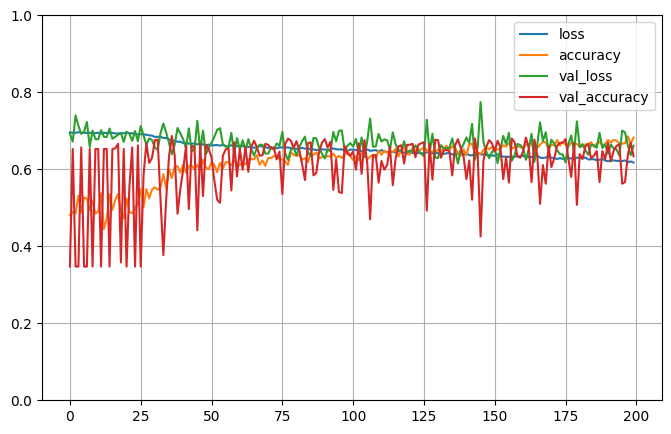


2023-03-29 22:22:50.693723

Testing # 1 1
2023-03-29 22:22:50.694141
2023-03-29 22:22:50.694202
PREDICT
2023-03-29 22:22:50.702545
Test 1:0 485:258 65.28%
Predict 1:0 435:308 58.55%
Test sizes (743, 1025) (743,)
Range of scores: 0.03729403 to 0.9789704
Score threshold 0.5
Confusion matrix
 [[147 111]
 [161 324]]
Normalized matrix
 [[0.19784657 0.14939435]
 [0.2166891  0.43606999]]


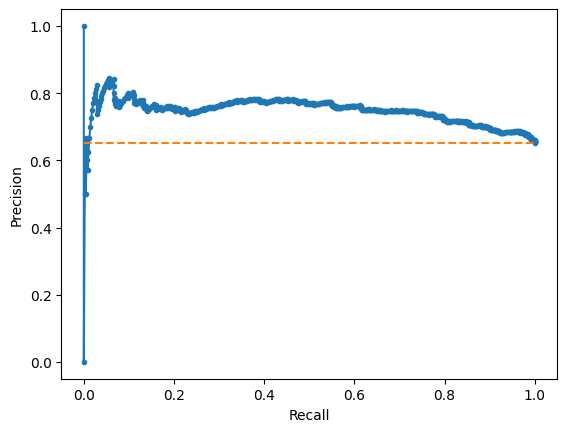

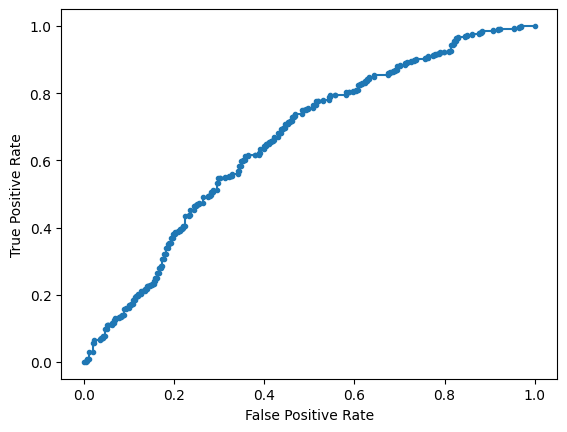

Accuracy: 63.39% Precision: 74.48% Recall: 66.80%
F1: 70.43% MCC: 0.2298
AUPRC: 74.71% AUROC: 65.86%
 accuracy [63.39165545087483]
 precision [74.48275862068967]
 recall [66.8041237113402]
 F1 [70.43478260869566]
 MCC [0.22982032579445866]
 AUPRC [74.71280376299188]
 AUROC [65.85710860704866]
2023-03-29 22:22:51.665590

Training # 1 2
2023-03-29 22:22:51.668381
2023-03-29 22:22:51.668797
Discriminator is GMM
Means [0.3094076773295633, -1.5548887801319904]
Variances [1.51932962 1.68273315]
Priors [0.58914384 0.41085616]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1900:1112 63.08%
Computed class weights: {0: 1.35431654676259, 1: 0.7926315789473685}
Valid 1:0 481:281 63.12%
FIT
2023-03-29 22:22:55.222010


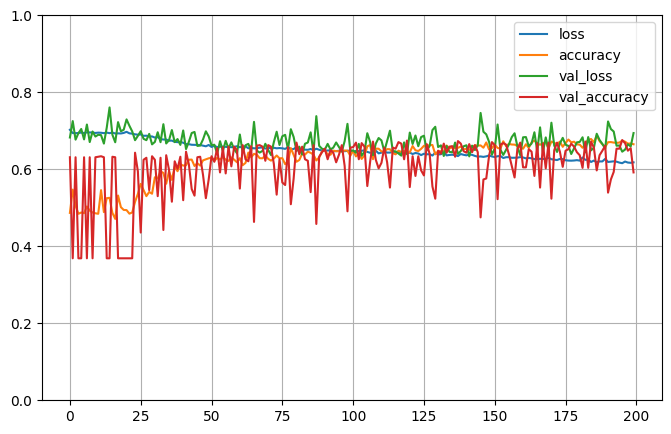


2023-03-29 22:25:18.455947

Testing # 1 2
2023-03-29 22:25:18.456066
2023-03-29 22:25:18.456122
PREDICT
2023-03-29 22:25:18.464640
Test 1:0 481:281 63.12%
Predict 1:0 372:390 48.82%
Test sizes (762, 1025) (762,)
Range of scores: 0.0117671685 to 0.9745567
Score threshold 0.5
Confusion matrix
 [[180 101]
 [210 271]]
Normalized matrix
 [[0.23622047 0.13254593]
 [0.27559055 0.35564304]]


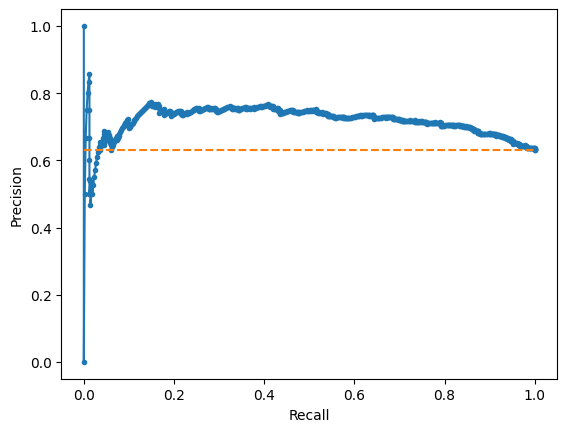

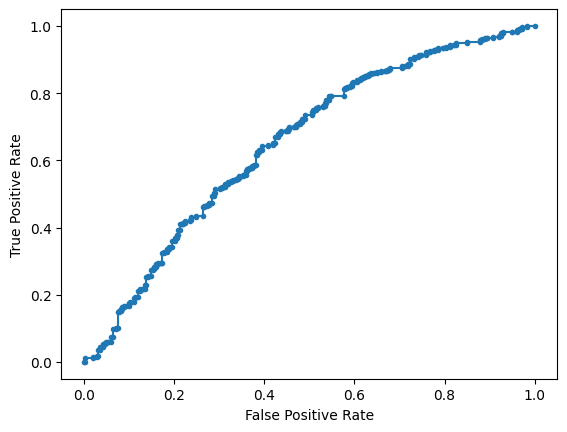

Accuracy: 59.19% Precision: 72.85% Recall: 56.34%
F1: 63.54% MCC: 0.1969
AUPRC: 71.75% AUROC: 65.13%
 accuracy [59.186351706036746]
 precision [72.84946236559139]
 recall [56.34095634095634]
 F1 [63.54044548651817]
 MCC [0.1968825812119648]
 AUPRC [71.74865834731973]
 AUROC [65.12677473531568]
2023-03-29 22:25:19.133014

Training # 1 3
2023-03-29 22:25:19.134771
2023-03-29 22:25:19.134846
Discriminator is GMM
Means [0.2662560700267227, -1.6008833461884069]
Variances [1.49507866 1.715452  ]
Priors [0.59976732 0.40023268]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 1995:1036 65.82%
Computed class weights: {0: 1.462837837837838, 1: 0.7596491228070176}
Valid 1:0 494:249 66.49%
FIT
2023-03-29 22:25:20.420468


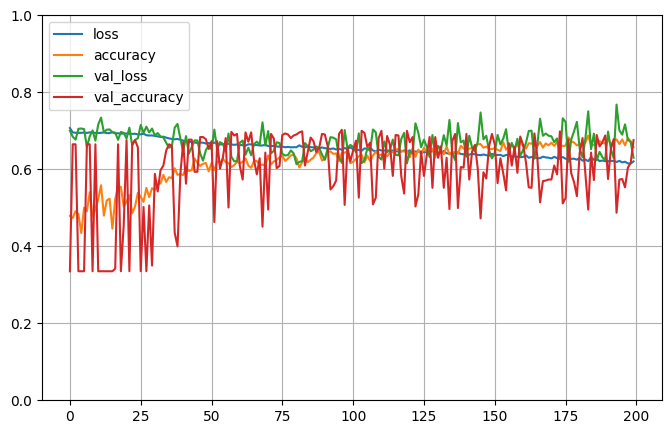


2023-03-29 22:26:44.011443

Testing # 1 3
2023-03-29 22:26:44.011554
2023-03-29 22:26:44.011877
PREDICT
2023-03-29 22:26:44.029404
Test 1:0 494:249 66.49%
Predict 1:0 539:204 72.54%
Test sizes (743, 1025) (743,)
Range of scores: 0.0099461805 to 0.9485619
Score threshold 0.5
Confusion matrix
 [[106 143]
 [ 98 396]]
Normalized matrix
 [[0.14266487 0.19246299]
 [0.13189771 0.53297443]]


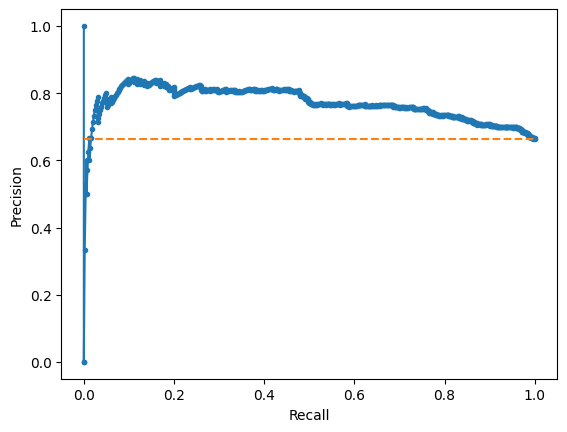

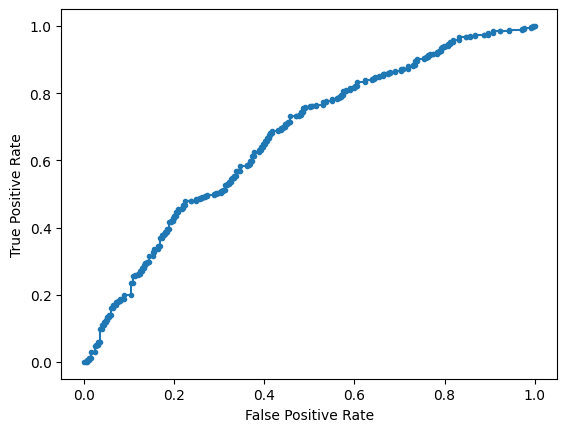

Accuracy: 67.56% Precision: 73.47% Recall: 80.16%
F1: 76.67% MCC: 0.2404
AUPRC: 76.82% AUROC: 66.80%
 accuracy [67.56393001345896]
 precision [73.46938775510205]
 recall [80.16194331983806]
 F1 [76.66989351403679]
 MCC [0.2404338535079187]
 AUPRC [76.81919413341171]
 AUROC [66.79836755930604]
2023-03-29 22:26:44.719570

Training # 1 4
2023-03-29 22:26:44.719808
2023-03-29 22:26:44.719876
Discriminator is GMM
Means [0.3089326496260968, -1.6297957974272412]
Variances [1.48095281 1.68289641]
Priors [0.60506438 0.39493562]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2007:1019 66.33%
Computed class weights: {0: 1.4847890088321885, 1: 0.7538614848031888}
Valid 1:0 475:273 63.50%
FIT
2023-03-29 22:26:48.466525


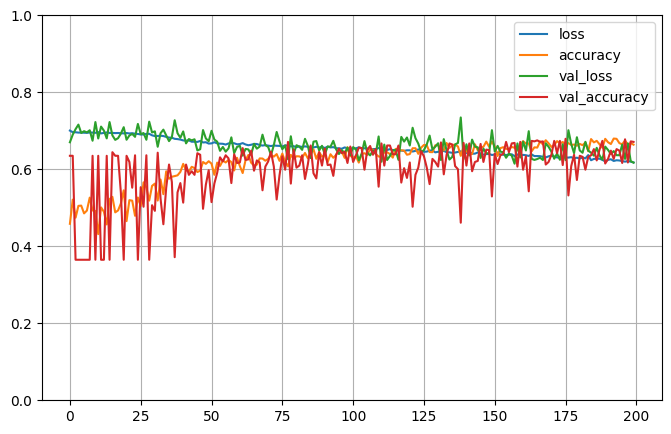


2023-03-29 22:28:10.706677

Testing # 1 4
2023-03-29 22:28:10.706809
2023-03-29 22:28:10.706855
PREDICT
2023-03-29 22:28:10.720354
Test 1:0 475:273 63.50%
Predict 1:0 613:135 81.95%
Test sizes (748, 1025) (748,)
Range of scores: 0.02941556 to 0.96523875
Score threshold 0.5
Confusion matrix
 [[ 81 192]
 [ 54 421]]
Normalized matrix
 [[0.10828877 0.25668449]
 [0.07219251 0.56283422]]


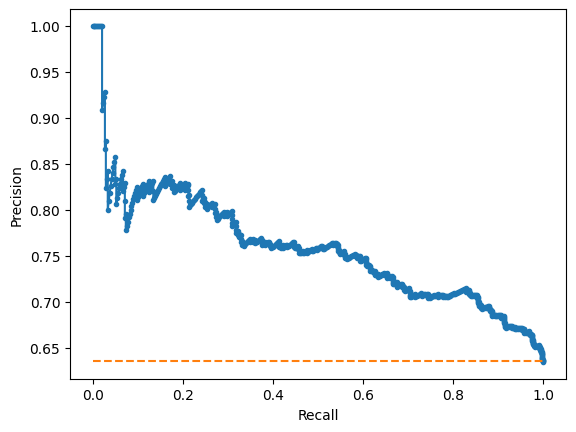

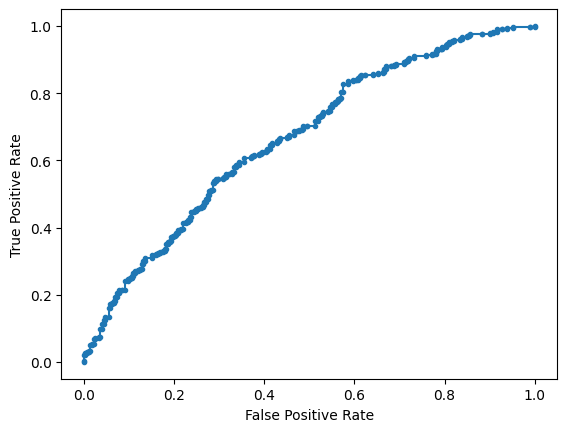

Accuracy: 67.11% Precision: 68.68% Recall: 88.63%
F1: 77.39% MCC: 0.2291
AUPRC: 75.82% AUROC: 66.52%
 accuracy [67.11229946524064]
 precision [68.67862969004894]
 recall [88.63157894736841]
 F1 [77.38970588235294]
 MCC [0.22910121341190645]
 AUPRC [75.81684818530003]
 AUROC [66.524002313476]
2023-03-29 22:28:11.735703

Training # 1 5
2023-03-29 22:28:11.735999
2023-03-29 22:28:11.736070
Discriminator is GMM
Means [-1.5778002270564924, 0.30048306582765444]
Variances [1.69715691 1.54615189]
Priors [0.40281236 0.59718764]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1907:1089 63.65%
Computed class weights: {0: 1.3755739210284665, 1: 0.7855270057682223}
Valid 1:0 492:286 63.24%
FIT
2023-03-29 22:28:14.381209


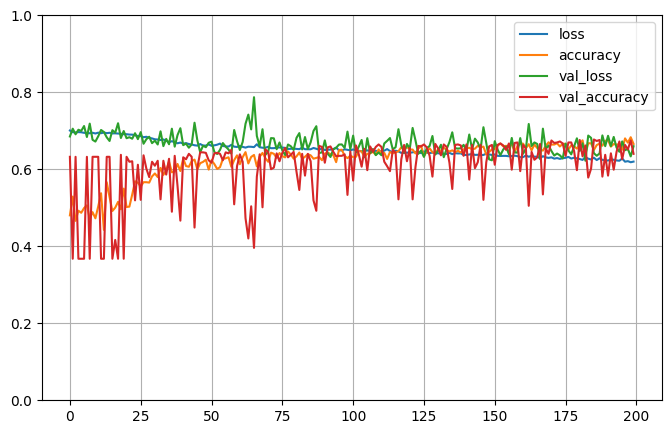


2023-03-29 22:30:38.113961

Testing # 1 5
2023-03-29 22:30:38.115714
2023-03-29 22:30:38.116123
PREDICT
2023-03-29 22:30:38.132735
Test 1:0 492:286 63.24%
Predict 1:0 434:344 55.78%
Test sizes (778, 1025) (778,)
Range of scores: 0.03678021 to 0.9018842
Score threshold 0.5
Confusion matrix
 [[175 111]
 [169 323]]
Normalized matrix
 [[0.22493573 0.14267352]
 [0.21722365 0.4151671 ]]


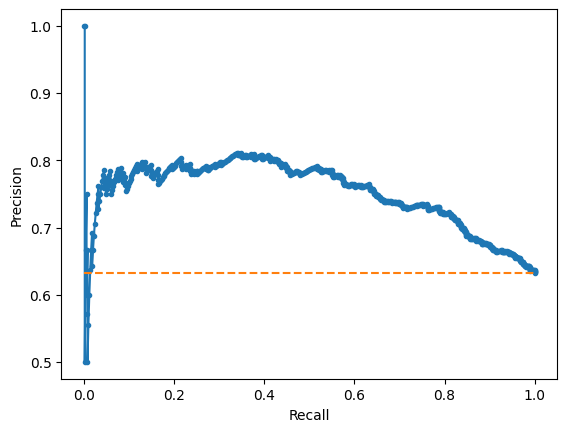

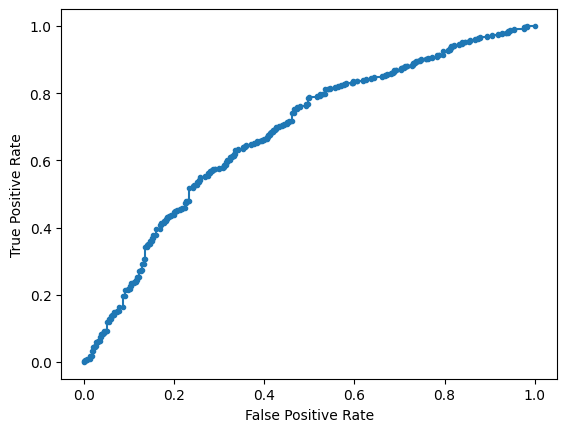

Accuracy: 64.01% Precision: 74.42% Recall: 65.65%
F1: 69.76% MCC: 0.2606
AUPRC: 75.18% AUROC: 68.10%
 accuracy [64.01028277634961]
 precision [74.42396313364056]
 recall [65.65040650406505]
 F1 [69.76241900647948]
 MCC [0.2605621534233557]
 AUPRC [75.18008660142492]
 AUROC [68.09724828017511]
2023-03-29 22:30:39.224775

Training # 2 1
2023-03-29 22:30:39.227131
2023-03-29 22:30:39.227599
Discriminator is GMM
Means [0.317163896499089, -1.6256438705245089]
Variances [1.5161267  1.61263147]
Priors [0.59412738 0.40587262]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1908:1115 63.12%
Computed class weights: {0: 1.3556053811659192, 1: 0.7921907756813418}
Valid 1:0 486:265 64.71%
FIT
2023-03-29 22:30:42.284872


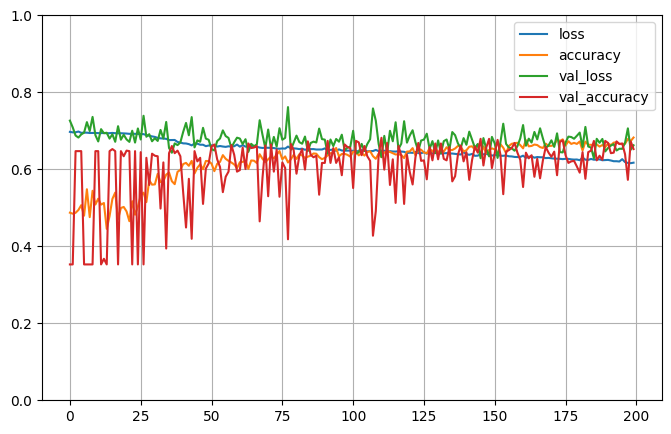


2023-03-29 22:33:05.879355

Testing # 2 1
2023-03-29 22:33:05.879477
2023-03-29 22:33:05.879528
PREDICT
2023-03-29 22:33:05.894393
Test 1:0 486:265 64.71%
Predict 1:0 475:276 63.25%
Test sizes (751, 1025) (751,)
Range of scores: 0.023144903 to 0.9864435
Score threshold 0.5
Confusion matrix
 [[140 125]
 [136 350]]
Normalized matrix
 [[0.18641811 0.16644474]
 [0.18109188 0.46604527]]


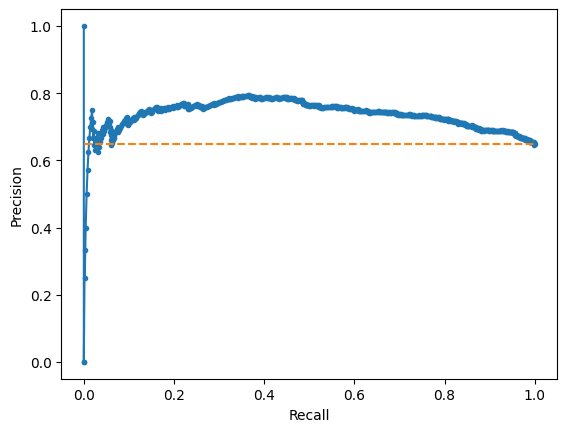

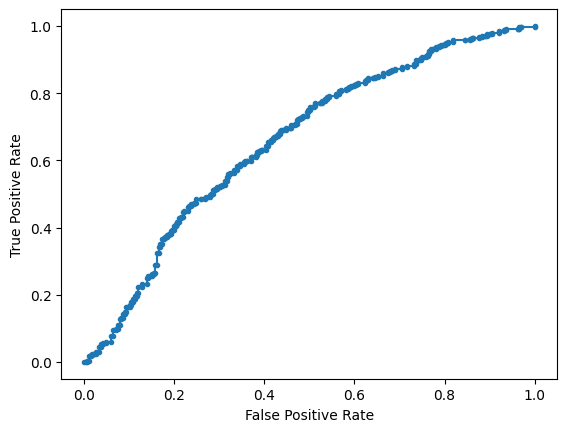

Accuracy: 65.25% Precision: 73.68% Recall: 72.02%
F1: 72.84% MCC: 0.2463
AUPRC: 73.50% AUROC: 65.89%
 accuracy [65.24633821571238]
 precision [73.68421052631578]
 recall [72.0164609053498]
 F1 [72.84079084287201]
 MCC [0.24626776041023077]
 AUPRC [73.49873407869715]
 AUROC [65.89253824054661]
2023-03-29 22:33:06.872160

Training # 2 2
2023-03-29 22:33:06.872487
2023-03-29 22:33:06.872571
Discriminator is GMM
Means [-1.5691371586210736, 0.2882936311504752]
Variances [1.69032921 1.52141437]
Priors [0.40484461 0.59515539]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1921:1107 63.44%
Computed class weights: {0: 1.3676603432700993, 1: 0.7881311816762103}
Valid 1:0 476:270 63.81%
FIT
2023-03-29 22:33:13.699370


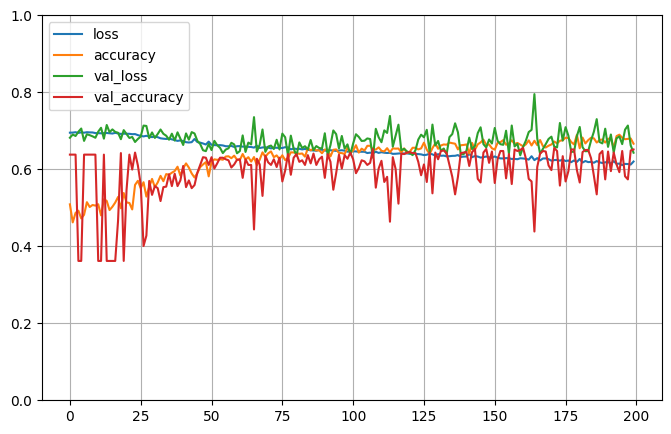


2023-03-29 22:35:37.254641

Testing # 2 2
2023-03-29 22:35:37.256387
2023-03-29 22:35:37.256777
PREDICT
2023-03-29 22:35:37.268352
Test 1:0 476:270 63.81%
Predict 1:0 598:148 80.16%
Test sizes (746, 1025) (746,)
Range of scores: 0.04054223 to 0.98204464
Score threshold 0.5
Confusion matrix
 [[ 79 191]
 [ 69 407]]
Normalized matrix
 [[0.10589812 0.25603217]
 [0.0924933  0.54557641]]


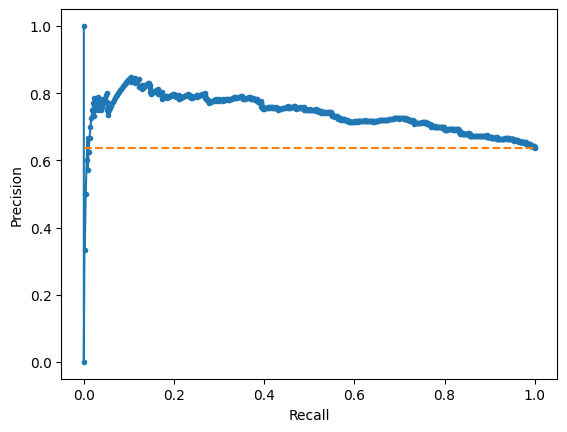

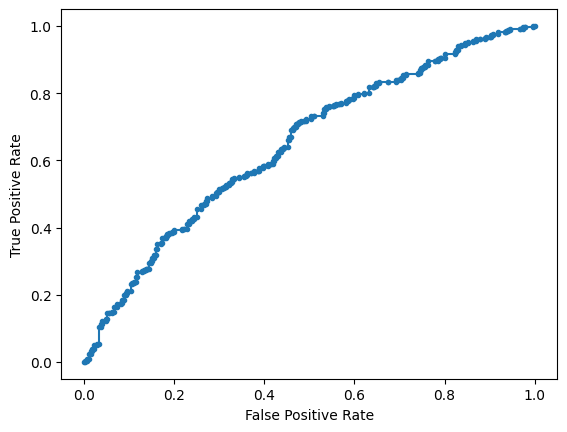

Accuracy: 65.15% Precision: 68.06% Recall: 85.50%
F1: 75.79% MCC: 0.1779
AUPRC: 73.87% AUROC: 64.52%
 accuracy [65.14745308310992]
 precision [68.06020066889631]
 recall [85.50420168067227]
 F1 [75.79143389199255]
 MCC [0.1779066115612555]
 AUPRC [73.86952818227155]
 AUROC [64.52225334578276]
2023-03-29 22:35:38.376726

Training # 2 3
2023-03-29 22:35:38.378757
2023-03-29 22:35:38.379162
Discriminator is GMM
Means [0.288713874407975, -1.482514501146511]
Variances [1.59602786 1.75647713]
Priors [0.57427804 0.42572196]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1874:1137 62.24%
Computed class weights: {0: 1.324098504837291, 1: 0.8033617929562433}
Valid 1:0 475:288 62.25%
FIT
2023-03-29 22:35:41.978356


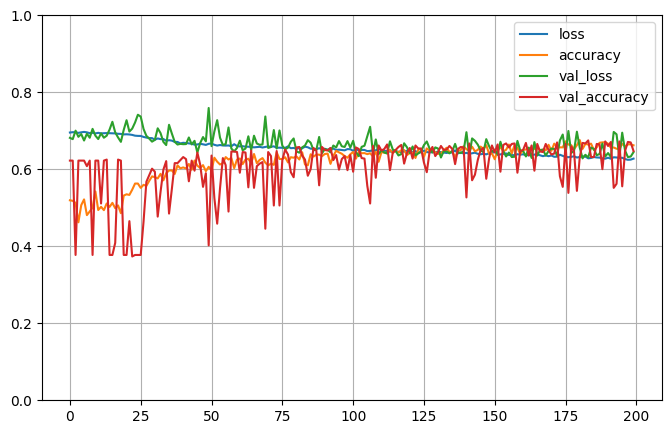


2023-03-29 22:38:05.354859

Testing # 2 3
2023-03-29 22:38:05.354971
2023-03-29 22:38:05.355024
PREDICT
2023-03-29 22:38:05.367023
Test 1:0 475:288 62.25%
Predict 1:0 500:263 65.53%
Test sizes (763, 1025) (763,)
Range of scores: 0.026131012 to 0.9023077
Score threshold 0.5
Confusion matrix
 [[141 147]
 [122 353]]
Normalized matrix
 [[0.18479685 0.19266055]
 [0.15989515 0.46264744]]


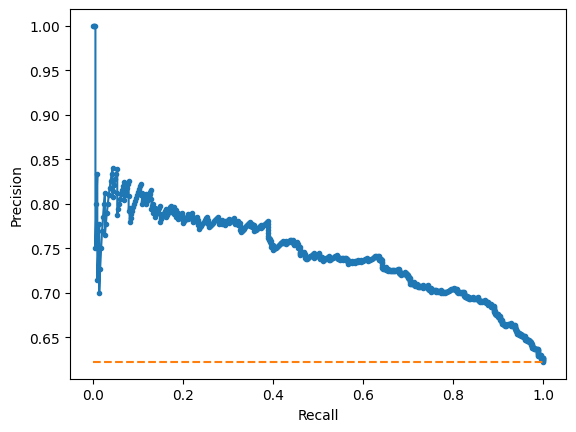

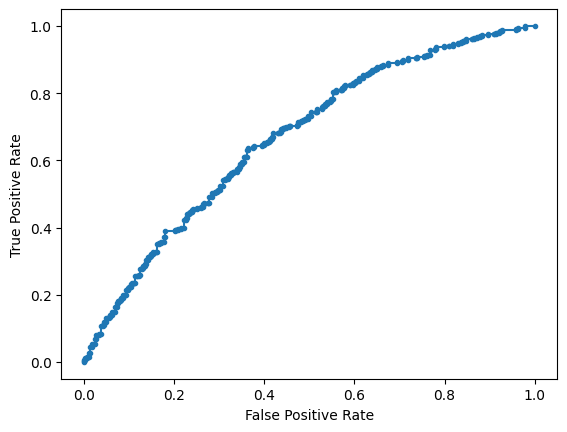

Accuracy: 64.74% Precision: 70.60% Recall: 74.32%
F1: 72.41% MCC: 0.2374
AUPRC: 74.31% AUROC: 66.85%
 accuracy [64.74442988204456]
 precision [70.6]
 recall [74.31578947368422]
 F1 [72.41025641025641]
 MCC [0.23738512067379114]
 AUPRC [74.31024281648992]
 AUROC [66.84795321637426]
2023-03-29 22:38:06.070114

Training # 2 4
2023-03-29 22:38:06.071900
2023-03-29 22:38:06.072354
Discriminator is GMM
Means [0.24976188933308363, -1.5307801778579202]
Variances [1.56522542 1.79763989]
Priors [0.59663595 0.40336405]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2004:1024 66.18%
Computed class weights: {0: 1.478515625, 1: 0.7554890219560878}
Valid 1:0 486:260 65.15%
FIT
2023-03-29 22:38:08.565578


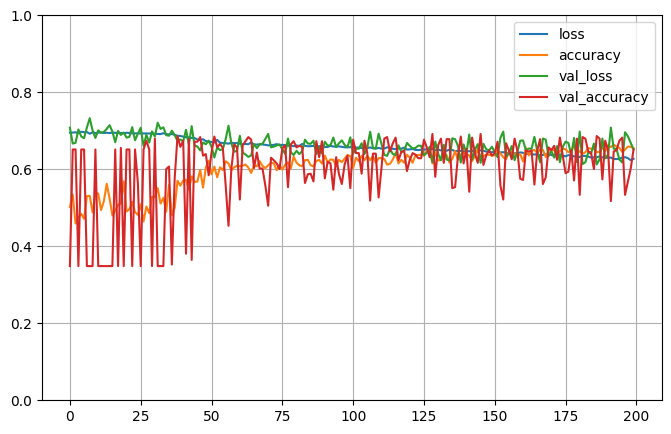


2023-03-29 22:39:31.912731

Testing # 2 4
2023-03-29 22:39:31.912853
2023-03-29 22:39:31.912903
PREDICT
2023-03-29 22:39:31.923115
Test 1:0 486:260 65.15%
Predict 1:0 420:326 56.30%
Test sizes (746, 1025) (746,)
Range of scores: 0.023007663 to 0.9390186
Score threshold 0.5
Confusion matrix
 [[163  97]
 [163 323]]
Normalized matrix
 [[0.21849866 0.13002681]
 [0.21849866 0.43297587]]


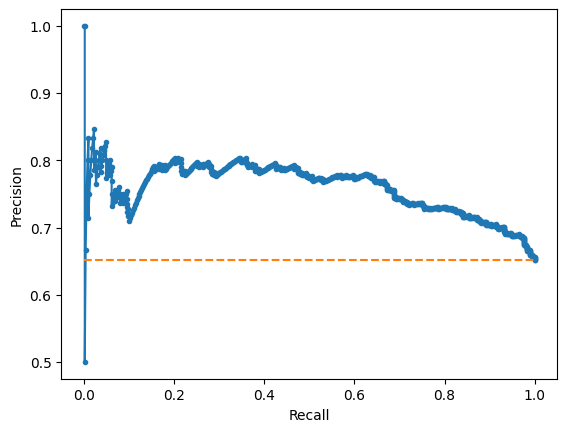

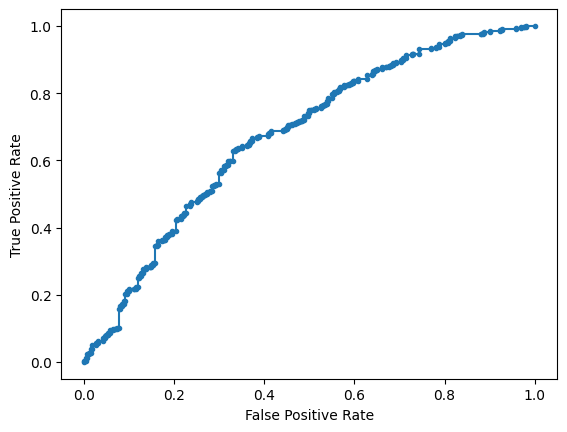

Accuracy: 65.15% Precision: 76.90% Recall: 66.46%
F1: 71.30% MCC: 0.2801
AUPRC: 75.91% AUROC: 67.44%
 accuracy [65.14745308310992]
 precision [76.90476190476191]
 recall [66.46090534979425]
 F1 [71.30242825607066]
 MCC [0.280064323978716]
 AUPRC [75.90885617494119]
 AUROC [67.43827160493827]
2023-03-29 22:39:32.582753

Training # 2 5
2023-03-29 22:39:32.583057
2023-03-29 22:39:32.583129
Discriminator is GMM
Means [0.3008758754641723, -1.5812926407653882]
Variances [1.44695799 1.72758448]
Priors [0.59185485 0.40814515]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1910:1096 63.54%
Computed class weights: {0: 1.3713503649635037, 1: 0.7869109947643979}
Valid 1:0 486:282 63.28%
FIT
2023-03-29 22:39:34.469460


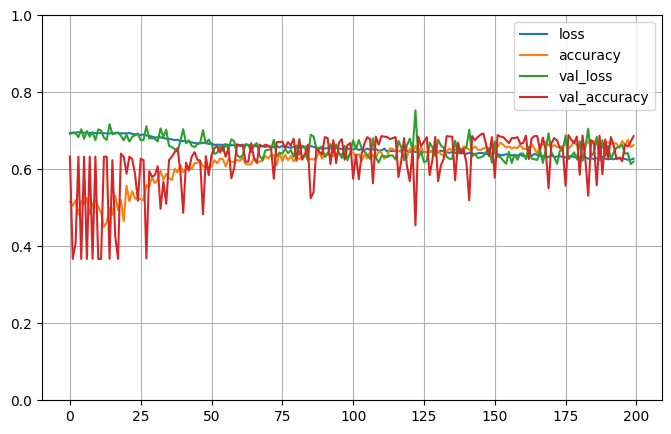


2023-03-29 22:40:59.011385

Testing # 2 5
2023-03-29 22:40:59.016432
2023-03-29 22:40:59.016811
PREDICT
2023-03-29 22:40:59.023041
Test 1:0 486:282 63.28%
Predict 1:0 583:185 75.91%
Test sizes (768, 1025) (768,)
Range of scores: 0.048477564 to 0.9557188
Score threshold 0.5
Confusion matrix
 [[113 169]
 [ 72 414]]
Normalized matrix
 [[0.14713542 0.22005208]
 [0.09375    0.5390625 ]]


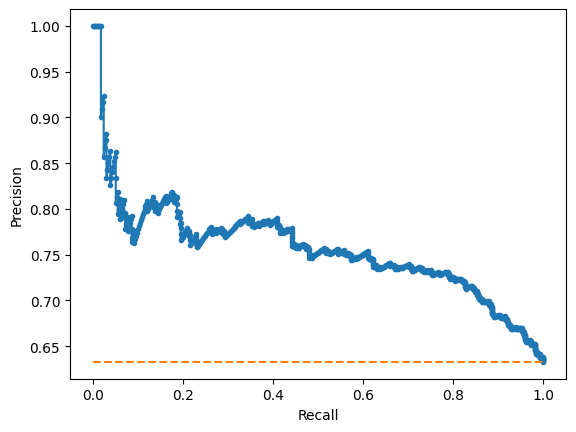

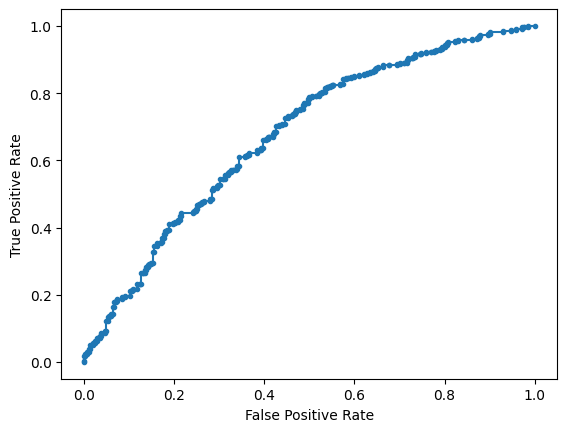

Accuracy: 68.62% Precision: 71.01% Recall: 85.19%
F1: 77.46% MCC: 0.2847
AUPRC: 75.67% AUROC: 67.54%
 accuracy [68.61979166666666]
 precision [71.01200686106347]
 recall [85.18518518518519]
 F1 [77.4555659494855]
 MCC [0.2847009779602374]
 AUPRC [75.6662242860048]
 AUROC [67.54078743834458]
2023-03-29 22:40:59.971520


In [27]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [28]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 65.02% std 2.62
 precision mean 72.42% std 2.78
 recall mean 74.11% std 10.56
 F1 mean 72.76% std 4.34
 MCC mean 0.24% std 0.03
 AUPRC mean 74.75% std 1.47
 AUROC mean 66.46% std 1.12
 accuracy [[63.39165545087483], [59.186351706036746], [67.56393001345896], [67.11229946524064], [64.01028277634961], [65.24633821571238], [65.14745308310992], [64.74442988204456], [65.14745308310992], [68.61979166666666]]
 precision [[74.48275862068967], [72.84946236559139], [73.46938775510205], [68.67862969004894], [74.42396313364056], [73.68421052631578], [68.06020066889631], [70.6], [76.90476190476191], [71.01200686106347]]
 recall [[66.8041237113402], [56.34095634095634], [80.16194331983806], [88.63157894736841], [65.65040650406505], [72.0164609053498], [85.50420168067227], [74.31578947368422], [66.46090534979425], [85.18518518518519]]
 F1 [[70.43478260869566], [63.54044548651817], [76.66989351403679], [77.38970588235294], [69.76241900647948], [72.84079084287201], [75.79143389199255], [